<a href="https://colab.research.google.com/github/ImajiPietersz/FYP/blob/main/GAN_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATASET_PATH = '/content/drive/MyDrive/LoRaWANdataset/machine2WithNoise.csv'
IMP_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg', 'ZRMSmg','converted', 'target']
X_COL = ['XOAVelocity', 'XPeakmg', 'XRMSmg', 'XKurtosis',
       'XCrestFactor', 'XSkewness', 'XDeviation', 'XPeaktoPeakDisplacement',
       'YOAVelocity', 'YPeakmg', 'YRMSmg', 'ZOAVelocity', 'ZPeakmg','converted', 'ZRMSmg']
TAR_COL = 'target'

In [3]:
df = pd.read_csv(DATASET_PATH)[IMP_COL]
df


,XOAVelocity,XPeakmg,XRMSmg,XKurtosis,XCrestFactor,XSkewness,XDeviation,XPeaktoPeakDisplacement,YOAVelocity,YPeakmg,YRMSmg,ZOAVelocity,ZPeakmg,ZRMSmg,converted,target
0,7,18,13,-5,38,-4,8,1,8,11,8,20,156,111,2022-12-12 05:13,0
1,67,183,130,22,197,8,531,6,38,137,97,85,390,276,2022-12-12 05:19,0
2,20,48,34,-3,203,1,204,2,18,36,26,63,216,153,2022-12-12 05:19,0
3,218,305,216,-36,132,-5,291,23,232,306,217,132,117,83,2022-12-12 05:19,0
4,9,18,13,3,1039,-1,8,1,9,12,9,16,107,76,2022-12-12 05:43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3841,58,91,65,-15,925,-1,26,4,58,77,55,157,871,616,2023-05-04 04:43,0
3842,30,76,54,-5,1201,0,373,3,36,72,51,101,265,188,2023-05-04 04:48,0
3843,63,169,120,512,3043,5,583,8,186,422,299,188,405,287,2023-05-04 04:50,0
3844,170,162,115,68,936,0,227,22,265,214,152,460,237,168,2023-05-04 04:50,0


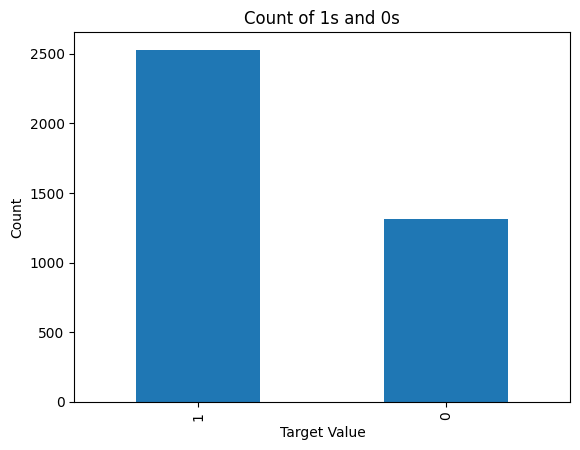

1    2529
0    1317
Name: target, dtype: int64


In [6]:
target_counts = df['target'].value_counts()

# Create a bar chart of the counts
target_counts.plot.bar()

# Add labels and title to the chart
plt.title('Count of 1s and 0s')
plt.xlabel('Target Value')
plt.ylabel('Count')

# Display the chart
plt.show()
print(target_counts)

<ipython-input-7-2d366cf5db0b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target -= 1
<ipython-input-7-2d366cf5db0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.target *= 40


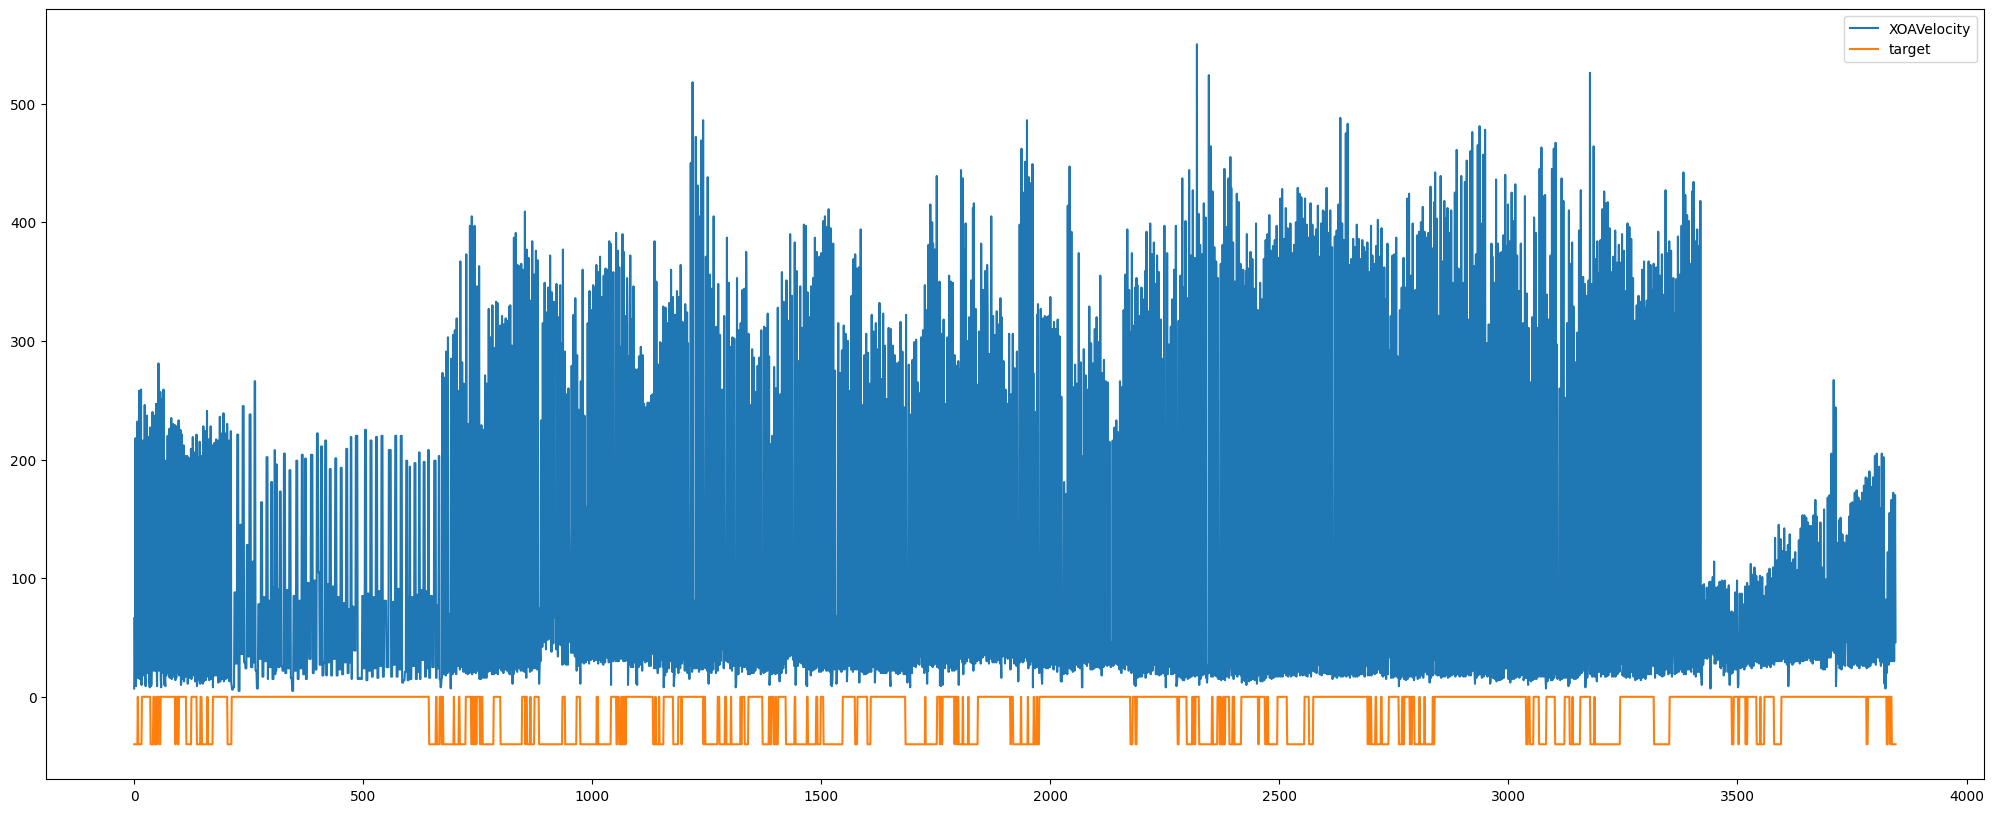

In [7]:
df1 = df.drop(['XCrestFactor','ZPeakmg','ZRMSmg'], axis=1)
df1 = df[['XOAVelocity','target']]
df1.target -= 1
df1.target *= 40
plt.figure(figsize=(25,10)) 
plt.plot(df1)
plt.legend(df1.columns)
plt.show()

In [11]:
def generateFrames(size = 6,overlap = True):
  # generate overlapping frames
  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0, len(df), 1 if overlap else size) if i < len(df) - size]
  data = []
  labels = []

  for d in list_of_dfs:
    if(len(d)==size):
      values = d[['XOAVelocity']].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      data.append(values)

      # label as 1 if not noisy false otherwise
      labels.append(d['target'].sum() < 3)

  labels = np.asarray(labels, dtype=bool) 
  data = np.array(data)

  return (data,labels)

def splitTrainTest(ratio, data, labels):
  
  x_train, x_test,_ = np.split(data, [round(len(data) * ratio), len(data)])
  labels_train, labels_test,_ = np.split(labels, [round(len(labels) * ratio), len(labels)])

  return (x_train,x_test, labels_train,labels_test)

In [ ]:
from sklearn.model_selection import train_test_split
frames, labels = generateFrames(12)
train_data,test_data, train_labels, test_labels =  splitTrainTest(0.6, frames, labels)

(len(train_data),len(test_data))
print(np.count_nonzero(train_data==False))
print(np.count_nonzero(train_data==True))
print(np.count_nonzero(test_data==False))
print(np.count_nonzero(test_data==True))


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(12,)),
    tf.keras.layers.Dense(12, activation='softmax'),
    tf.keras.layers.Dense(6, activation='softmax'),
    tf.keras.layers.Dense(3, activation='softmax'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Use K-fold cross-validation
k = 5
num_val_samples = len(frames) // k
num_epochs = 300
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = frames[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [frames[:i * num_val_samples],
         frames[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_labels = np.concatenate(
        [labels[:i * num_val_samples],
         labels[(i + 1) * num_val_samples:]],
        axis=0)

    history = model.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=num_epochs)
    scores = model.evaluate(val_data, val_labels)
    all_scores.append(scores)



In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Discriminator Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

class AutoEnc(Model):
  def __init__(self):
    super(AutoEnc, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(24, activation="relu"),
      layers.Dense(12, activation="relu"),
      layers.Dense(6, activation="relu"),
      layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(6, activation="relu"),
      layers.Dense(8, activation="relu"),
      layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEnc()
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(train_data, train_data, 
          epochs=3, validation_data=(test_data, test_data),
         )
 


In [8]:
def plotUsingAutoEncoder(model):
  size = 12
  list_of_dfs = [df.loc[i:i+size-1,:] for i in range(0,len(df),12)if i<len(df)-12]

  denoised = []

  for d in list_of_dfs:
    if(len(d)== size):
      values = d[['XOAVelocity']].values.flatten()
      min_val = tf.reduce_min(values)
      max_val = tf.reduce_max(values)
      values = (values - min_val) / (max_val - min_val)
      encoded_data = model.encoder( np.array([values])).numpy()
      [values] = model.decoder(encoded_data).numpy()
      values = (np.array(values) * (max_val - min_val).numpy())   + min_val.numpy()
      denoised = np.concatenate((np.array(denoised) , np.array(values)))

  denoised = np.array(denoised)
  noise = df[['XOAVelocity']].values.flatten()

  plt.figure(figsize=(20,5)) 
  plt.plot(noise)
  plt.plot(denoised, color="red")
  plt.legend(labels=["Input", "Reconstruction" ])
  plt.show()


# *WITH DESNE LAYERS*

In [19]:
from keras.layers.activation.leaky_relu import LeakyReLU
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Discriminator(Model):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(12,)),
        tf.keras.layers.Dense(12, activation='LeakyReLU'),
        tf.keras.layers.Dense(8, activation='LeakyReLU'),
        tf.keras.layers.Dense(6, activation='LeakyReLU'),
        tf.keras.layers.Dense(3, activation='softmax'),
        tf.keras.layers.Dense(1)
    ])

  def call(self, x):
    return self.model(x)

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(24, activation="relu"),
      tf.keras.layers.Dense(12, activation="relu"),
      tf.keras.layers.Dense(6, activation="relu"),
      tf.keras.layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(6, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

generator = Generator()
discriminator = Discriminator()

generator.compile(optimizer='adam',loss = 'mae')
discriminator.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

# Use K-fold cross-validation
k = 5
num_val_samples = len(frames) // k
num_epochs = 300
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = frames[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([frames[:i * num_val_samples],frames[(i + 1) * num_val_samples:]],axis=0)
    partial_train_labels = np.concatenate([labels[:i * num_val_samples],labels[(i + 1) * num_val_samples:]],axis=0)

    history = discriminator.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=num_epochs)
    scores = discriminator.evaluate(val_data, val_labels)
    all_scores.append(scores)


processing fold # 0
Epoch 1/300
96/96 [==============================] - 2s 9ms/step - loss: 0.6767 - accuracy: 0.7432 - val_loss: 0.5919 - val_accuracy: 0.8773
Epoch 2/300
96/96 [==============================] - 0s 3ms/step - loss: 0.6138 - accuracy: 0.7432 - val_loss: 0.5216 - val_accuracy: 0.8773
Epoch 3/300
96/96 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.7432 - val_loss: 0.4810 - val_accuracy: 0.8773
Epoch 4/300
96/96 [==============================] - 0s 3ms/step - loss: 0.5773 - accuracy: 0.7432 - val_loss: 0.4615 - val_accuracy: 0.8773
Epoch 5/300
96/96 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.7432 - val_loss: 0.4495 - val_accuracy: 0.8773
Epoch 6/300
96/96 [==============================] - 0s 3ms/step - loss: 0.5713 - accuracy: 0.7432 - val_loss: 0.4411 - val_accuracy: 0.8773
Epoch 7/300
96/96 [==============================] - 0s 3ms/step - loss: 0.5704 - accuracy: 0.7432 - val_loss: 0.4362 - val_accuracy: 

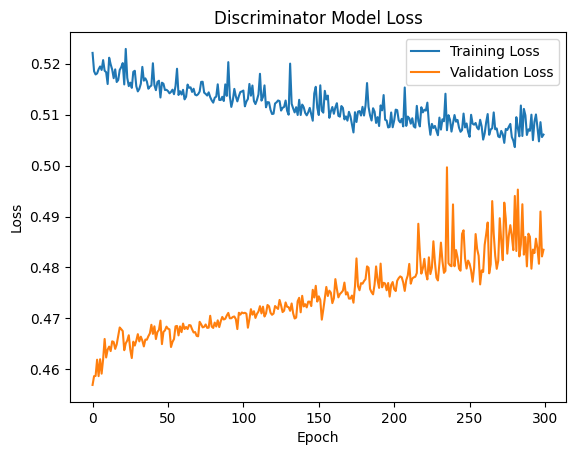

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Discriminator Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [21]:
max_epochs = 30
learning_rate = 0.001
generator_optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
step = 0
gen_losses = []
for epoch in range(max_epochs):
  print("Epoch " + str(epoch) +" Starting")

  for frame in train_data:
    #print(frame)
    with tf.GradientTape() as gen_tape:
      output = generator(np.array([frame]))
      disc_output = discriminator(np.array(output))

      mae = tf.keras.losses.MeanAbsoluteError()
      gen_loss = mae(frame, output[0]) * -disc_output[0][0]
  
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  gen_losses.append(gen_loss)
  
  print("Epoch " + str(epoch) +" DONE")

plotUsingAutoEncoder(generator)


Epoch 0 Starting


In [ ]:
plt.plot(gen_losses, label='Training Loss')
plt.title('Generator Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
print(len(gen_losses))

# *WITH 1D CNN LAYERS*


In [ ]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(12,)),
        tf.keras.layers.Reshape((12, 1)),  # Add a Reshape layer to prepare input for Conv1D
        tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation="LeakyReLU"),  # Replace 2nd Dense layer with Conv1D
        tf.keras.layers.Conv1D(filters=6, kernel_size=3, activation="LeakyReLU"),  # Add another Conv1D layer
        tf.keras.layers.Flatten(),  # Flatten the output of Conv1D for the next Dense layer
        tf.keras.layers.Dense(1)
    ])

  def call(self, x):
    return self.model(x)

class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(24, activation="relu"),
      tf.keras.layers.Reshape((24, 1)),  # Add a Reshape layer to prepare input for Conv1D
      tf.keras.layers.Conv1D(filters=12, kernel_size=3, activation="LeakyReLU"), 
      tf.keras.layers.Conv1D(filters=6, kernel_size=3, activation="LeakyReLU"), # Replace Dense layer with Conv1D
      tf.keras.layers.Flatten(),  # Flatten the output of Conv1D for the next Dense layer
      tf.keras.layers.Dense(3, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(6, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(12, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

generator = Generator()
discriminator = Discriminator()

generator.compile(optimizer='adam',loss = 'mae')
discriminator.compile(optimizer = 'adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

# Use K-fold cross-validation
k = 5
num_val_samples = len(frames) // k
num_epochs = 300
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = frames[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([frames[:i * num_val_samples],frames[(i + 1) * num_val_samples:]],axis=0)
    partial_train_labels = np.concatenate([labels[:i * num_val_samples],labels[(i + 1) * num_val_samples:]],axis=0)

    history = discriminator.fit(partial_train_data, partial_train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=num_epochs)
    scores = discriminator.evaluate(val_data, val_labels)
    all_scores.append(scores)



In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Discriminator Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
step = 0
gen_losses = []
for epoch in range(max_epochs):
  print("Epoch " + str(epoch) +" Starting")

  for frame in train_data:
    #print(frame)
    with tf.GradientTape() as gen_tape:
      output = generator(np.array([frame]))
      disc_output = discriminator(np.array(output))

      mae = tf.keras.losses.MeanAbsoluteError()
      gen_loss = mae(frame, output[0]) * -disc_output[0][0]
    gen_losses.append(gen_loss)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))

  
  print("Epoch " + str(epoch) +" DONE")

plotUsingAutoEncoder(generator)

In [ ]:
plt.plot(gen_losses, label='Training Loss')
plt.title('Generator Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
print(len(gen_losses))